In [5]:
import importlib.util
import os
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tqdm
import sys
import os.path as osp
from glob import glob

from zfa.core import frame_utils, default_dirs as dirs


In [12]:
def visualize_flow(img1, img2, flow):
    # Convert tensor images back to numpy arrays
    img1 = img1.permute(1, 2, 0).numpy().astype(np.uint8)  # [H, W, C]
    img2 = img2.permute(1, 2, 0).numpy().astype(np.uint8)  # [H, W, C]
    
    # Plot the two frames
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img1)
    axes[0].axis('off')  # Hide the axis to make the images cleaner

    axes[1].imshow(img2)
    axes[1].axis('off')  # Hide the axis
    
    # Use HSV model for colored flow visualization
    hsv = np.zeros_like(img1, dtype=np.uint8)
    hsv[..., 1] = 255  # Set saturation to max

    # Compute magnitude and angle of flow
    mag, ang = cv2.cartToPolar(flow[0].numpy(), flow[1].numpy())
    
    # Hue corresponds to flow direction, scaled between 0 and 180 degrees
    hsv[..., 0] = ang * 180 / np.pi / 2

    # Value (brightness) corresponds to flow magnitude, normalized between 0 and 255
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    
    # Convert HSV to BGR for visualization
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Display using matplotlib
    axes[2].imshow(bgr)
    axes[2].axis('off')  # Hide the axis

    plt.show()


def display_images(dataset, num_images=20):
    """Display num_images from the dataset without resizing or augmentation."""
    for i in range(num_images):
        img1, img2, flow = dataset[i]
        
        # Visualize the images and flow using the visualize_flow function
        visualize_flow(img1, img2, flow)


# Training set

In [7]:
class OpticFlowDataset(data.Dataset):
    def __init__(self, root_dir=dirs.MVK_FRAME_DIR, flow_dir=dirs.MVK_FLOW_DIR, split='train'):  
        """ Initialize the dataset """

        self.frame_dir = os.path.join(root_dir, split)
        self.flow_dir = os.path.join(flow_dir, split)
        self.image_list = []
        self.flow_list = []

        # Load all image sequences
        for scene in tqdm.tqdm(sorted(os.listdir(self.frame_dir)), desc="Loading dataset", file=sys.stdout):
            scene_path = osp.join(self.frame_dir, scene)
            images = sorted(glob(osp.join(scene_path, "*.png")))
            flow_path = osp.join(self.flow_dir, scene)
            flows = sorted(glob(osp.join(flow_path, "*.flo")))
            
            for i in range(len(images) - 1):
                self.image_list.append((images[i], images[i + 1]))
                self.flow_list.append(flows[i])

    def __len__(self):
        """ Return the number of frame pairs and flow files """
        return len(self.flow_list)

    def __getitem__(self, idx):
        """ Get a frame pair and corresponding flow file without augmentations or resizing """
        
        img1_path, img2_path = self.image_list[idx]
        img1 = frame_utils.read_gen(img1_path)
        img2 = frame_utils.read_gen(img2_path)
        flow_path = self.flow_list[idx]
        flow = frame_utils.read_gen(flow_path)
        
        # Convert to numpy arrays
        img1 = np.ascontiguousarray(img1)
        img2 = np.ascontiguousarray(img2)
        flow = np.ascontiguousarray(flow)

        # Convert to torch tensors (without any resizing or augmentations)
        img1 = torch.from_numpy(img1).permute(2, 0, 1).float()  # [C, H, W]
        img2 = torch.from_numpy(img2).permute(2, 0, 1).float()  # [C, H, W]
        flow = torch.from_numpy(flow).permute(2, 0, 1).float()  # [2, H, W]

        return img1, img2, flow


# Testing set

In [66]:

transform = Transform(size=size)
# Initialize the dataset and dataloader
dataset_test = OpticFlowDataset(split='test', transform=transform)

# Create DataLoader
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=True)



In [10]:
# Visualize a few batches
for i, (img1, img2, flow) in enumerate(dataloader_test):
    # Visualize the resized images and flow
    visualize_flow(img1[0], img2[0], flow[0])

    if i == 20:
        break

NameError: name 'dataloader_test' is not defined

Loading dataset: 100%|██████████| 1184/1184 [00:02<00:00, 434.30it/s]


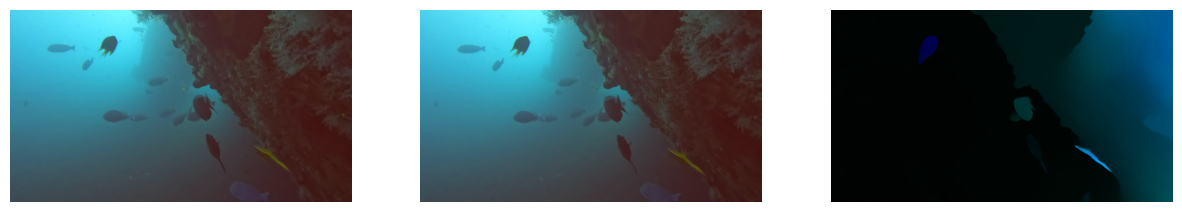

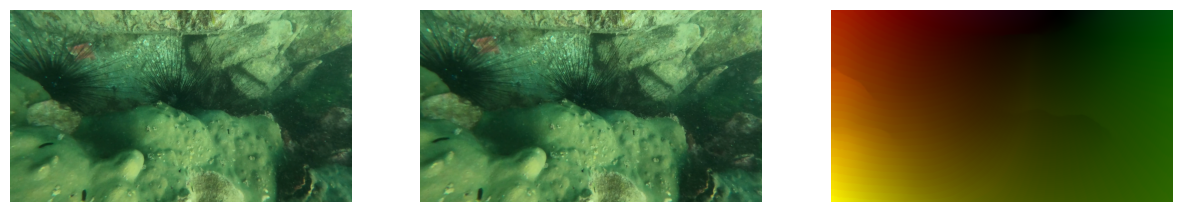

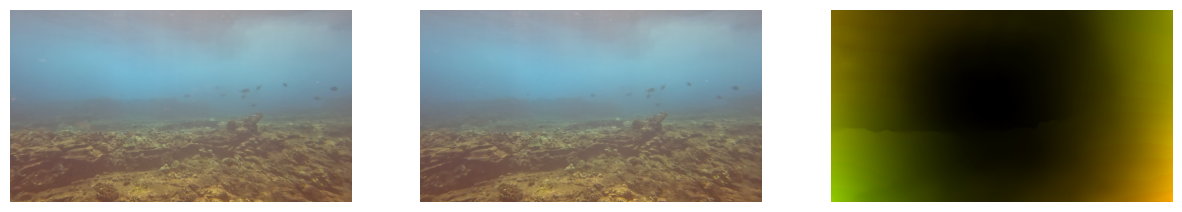

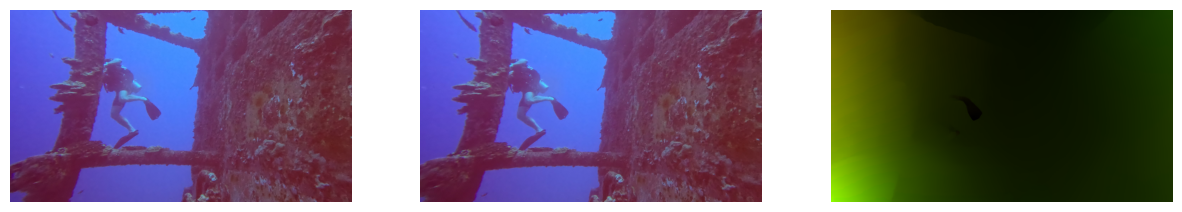

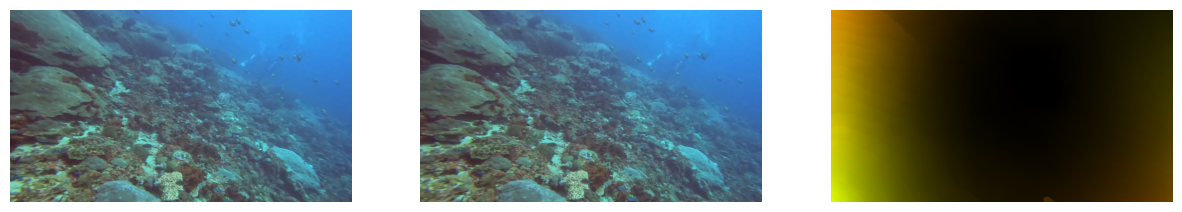

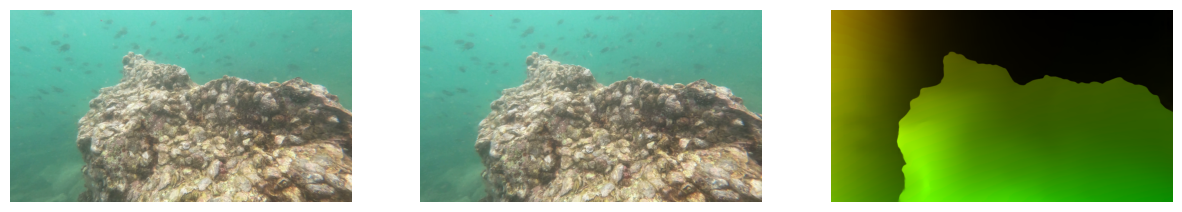

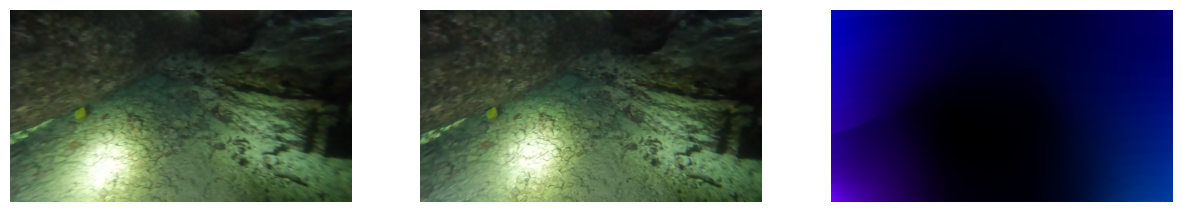

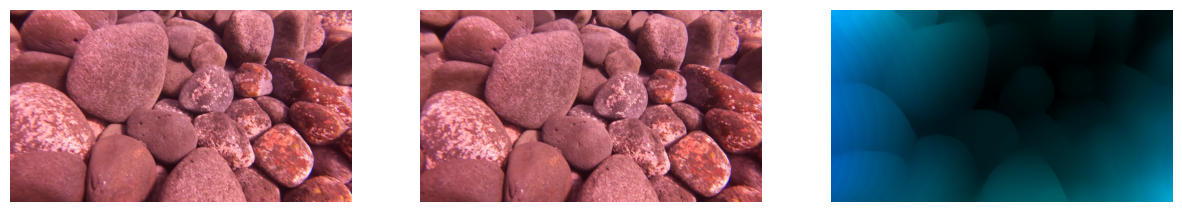

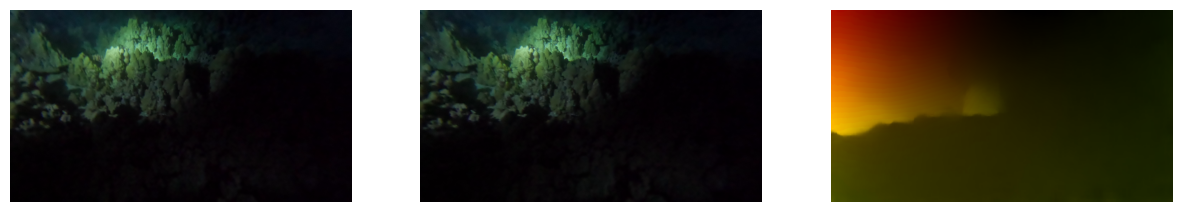

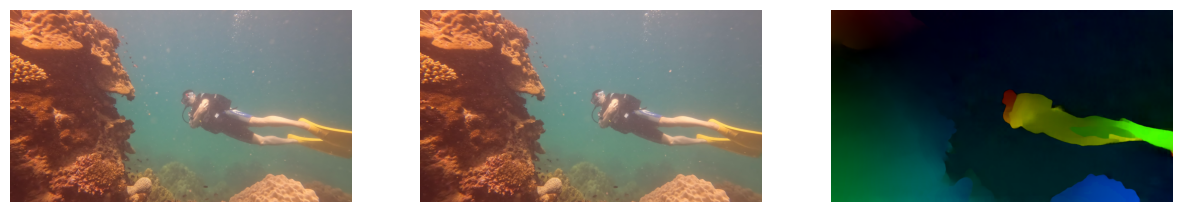

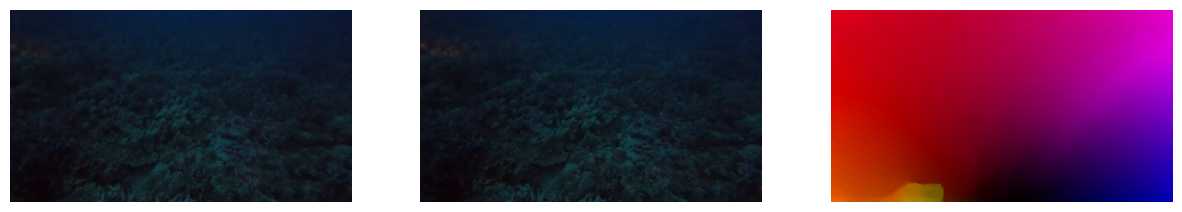

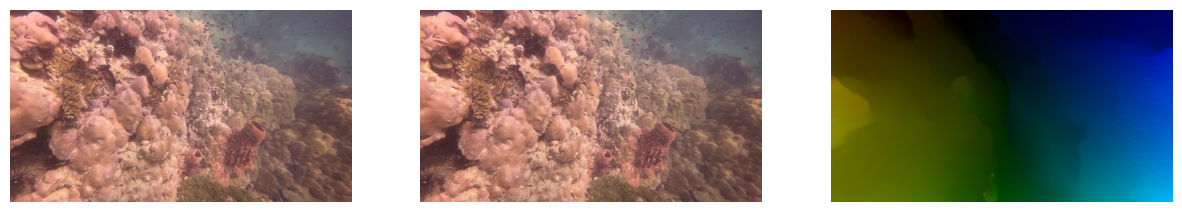

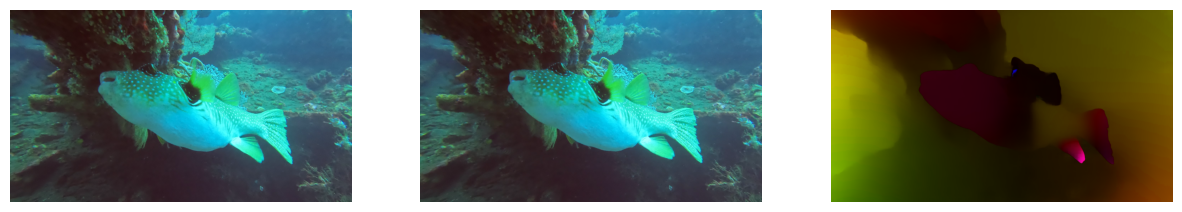

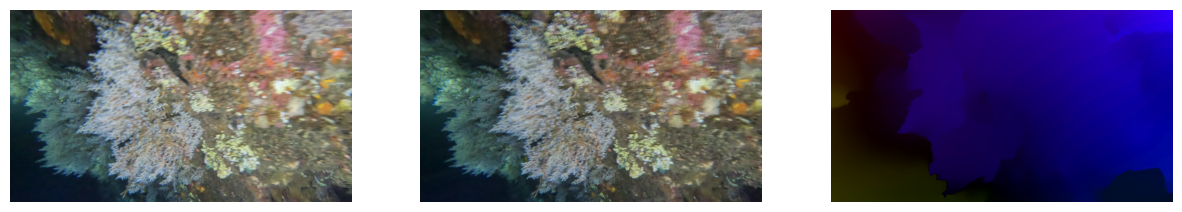

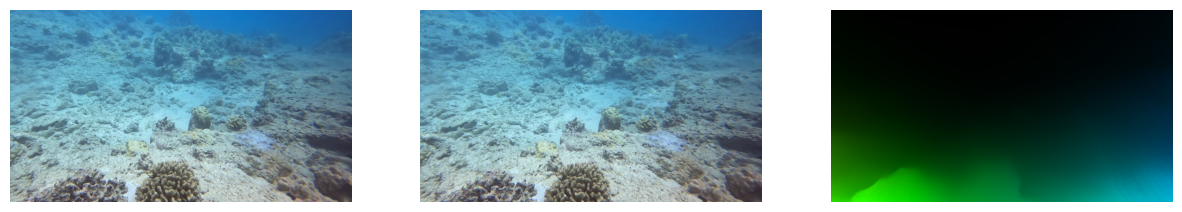

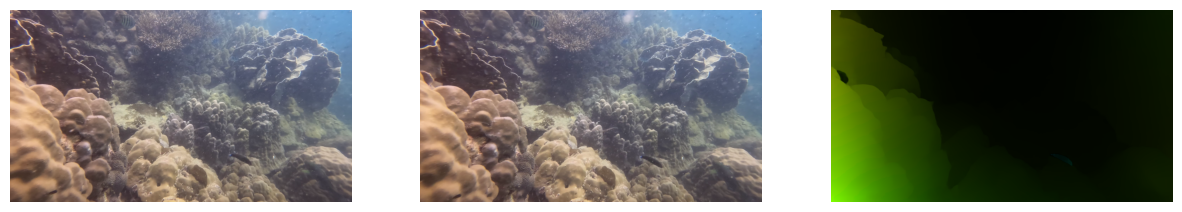

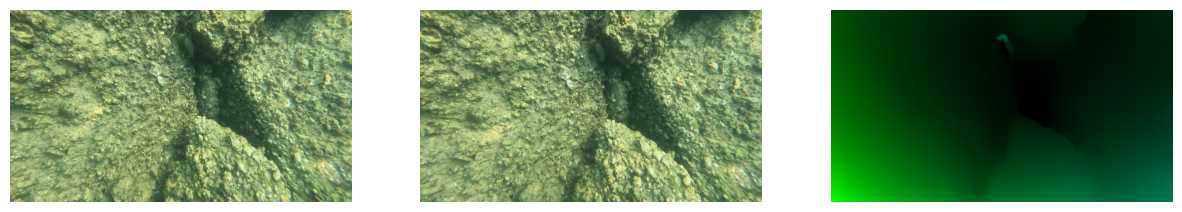

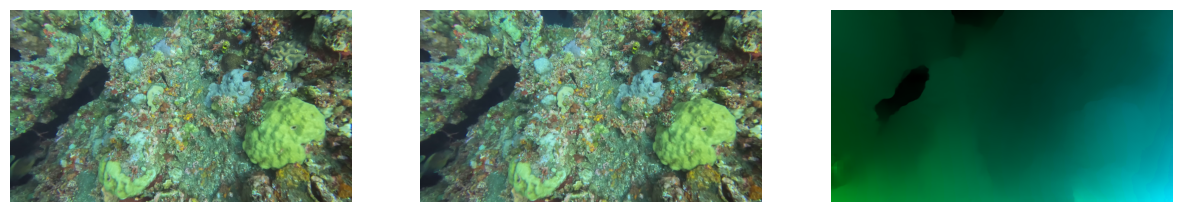

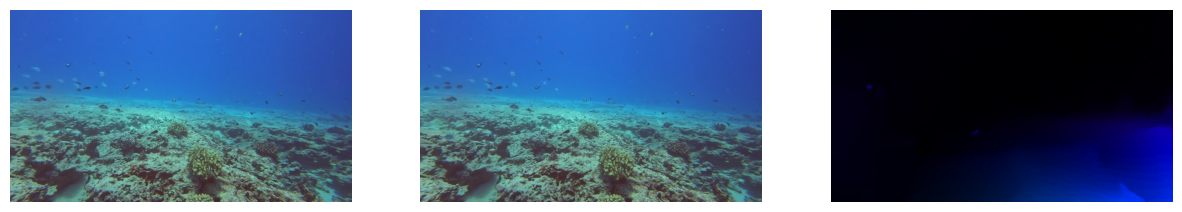

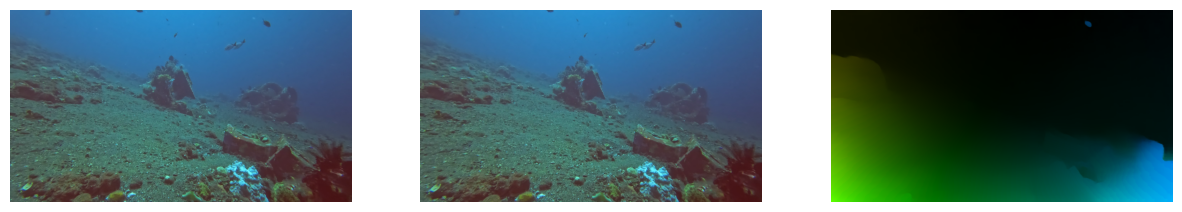

In [14]:
def display_random_images_dataloader(dataset, num_images=20, batch_size=5):
    """Display num_images randomly sampled from the dataset using DataLoader."""
    # Create a DataLoader with shuffle enabled
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Track how many images we've displayed
    images_displayed = 0

    for img1_batch, img2_batch, flow_batch in dataloader:
        for img1, img2, flow in zip(img1_batch, img2_batch, flow_batch):
            # Visualize each image and flow
            visualize_flow(img1, img2, flow)
            images_displayed += 1

            if images_displayed >= num_images:
                return  # Stop once we've displayed enough images

# Example usage
# Create the dataset
dataset = OpticFlowDataset(root_dir=dirs.MVK_FRAME_DIR, flow_dir=dirs.MVK_FLOW_DIR, split='train')

# Display 20 random images and flows
display_random_images_dataloader(dataset, num_images=20)